# US Elections

### Data Sources

- MIT Elections lab
- US Census CPS Tool Creator
- US States polygons

## Getting Started

Import all libraries needed for the project.

In [291]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import scatter_matrix

## 1. Reading data and setting up initial dataframes

In [292]:
nation = gpd.read_file("./data/nation.shp")

Import states shapefile as a dataframe.

Set the state `FID` to the index.

In [293]:
states_geo_df = gpd.read_file("./data/states.shp")
states_geo_df = states_geo_df.set_index("FID")
states_geo_df.head()

,geometry
FID,
05,"POLYGON ((558.824 -323.366, 559.353 -323.342, ..."
06,"MULTIPOLYGON (((38.962 -255.141, 38.572 -253.1..."
17,"POLYGON ((625.736 -191.428, 627.145 -193.035, ..."
20,"POLYGON ((501.558 -245.737, 502.088 -245.737, ..."
28,"MULTIPOLYGON (((633.352 -373.244, 633.332 -373..."


Import elections data.

Delete all rows with write in votes.

Create an `FID` column from `state_fips`.

In [294]:
p_elec_data = pd.read_csv("./data/1976-2016-president.csv")
p_elec_data = p_elec_data[p_elec_data.writein == False]
p_elec_data["FID"] = p_elec_data["state_fips"].astype(int).astype(str)
p_elec_data["FID"] = p_elec_data["FID"].apply(lambda x: '{0:0>2}'.format(x))
p_elec_data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,FID
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN,01
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN,01
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN,01
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN,01
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN,01


For Minnesota and North Dakota, change their democratic parties to `democrat` in column `party`.

In [295]:
p_elec_data[(p_elec_data.state_po == 'MN') & (p_elec_data.year == 2000)]

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,FID
2210,2000,Minnesota,MN,27,41,33,US President,"Gore, Al",democratic-farmer-labor,False,1168266,2438685,20171015,NaN,27
2211,2000,Minnesota,MN,27,41,33,US President,"Bush, George W.",republican,False,1109659,2438685,20171015,NaN,27
2212,2000,Minnesota,MN,27,41,33,US President,"Nader, Ralph",green,False,126696,2438685,20171015,NaN,27
2213,2000,Minnesota,MN,27,41,33,US President,"Buchanan, Patrick """"Pat""""",reform party minnesota,False,22166,2438685,20171015,NaN,27
2214,2000,Minnesota,MN,27,41,33,US President,"Browne, Harry",libertarian,False,5282,2438685,20171015,NaN,27
2215,2000,Minnesota,MN,27,41,33,US President,"Phillips, Howard",constitution party,False,3272,2438685,20171015,NaN,27
2216,2000,Minnesota,MN,27,41,33,US President,"Buchanan, Patrick """"Pat""""",reform party,False,2294,2438685,20171015,NaN,27
2217,2000,Minnesota,MN,27,41,33,US President,"Harris, James",socialist workers,False,1022,2438685,20171015,NaN,27


In [296]:
p_elec_data["party"] = np.where((p_elec_data.party == 'democratic-farmer-labor'), 
                                'democrat', p_elec_data.party)
p_elec_data.loc[(p_elec_data.party == 'democratic-farmer-labor') 
                | (p_elec_data.party == 'democratic-nonpartisan league') 
                | (p_elec_data.party == 'democratic-npl'),
                "party"] = 'democrat'
p_elec_data[(p_elec_data.state_po == 'MN') & (p_elec_data.year == 2000)]

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,FID
2210,2000,Minnesota,MN,27,41,33,US President,"Gore, Al",democrat,False,1168266,2438685,20171015,NaN,27
2211,2000,Minnesota,MN,27,41,33,US President,"Bush, George W.",republican,False,1109659,2438685,20171015,NaN,27
2212,2000,Minnesota,MN,27,41,33,US President,"Nader, Ralph",green,False,126696,2438685,20171015,NaN,27
2213,2000,Minnesota,MN,27,41,33,US President,"Buchanan, Patrick """"Pat""""",reform party minnesota,False,22166,2438685,20171015,NaN,27
2214,2000,Minnesota,MN,27,41,33,US President,"Browne, Harry",libertarian,False,5282,2438685,20171015,NaN,27
2215,2000,Minnesota,MN,27,41,33,US President,"Phillips, Howard",constitution party,False,3272,2438685,20171015,NaN,27
2216,2000,Minnesota,MN,27,41,33,US President,"Buchanan, Patrick """"Pat""""",reform party,False,2294,2438685,20171015,NaN,27
2217,2000,Minnesota,MN,27,41,33,US President,"Harris, James",socialist workers,False,1022,2438685,20171015,NaN,27


## 2. Manipulating data

Create a dictionary where the keys are every 4 years from `2004` to `2016`.

The year's corresponding dataframe is the value.

Create and calculate the `party ratio` column.

In [297]:
gby_year = p_elec_data.groupby("year")

elections_dict = {}
for year in gby_year.groups.keys():
    if year >= 2004:
        p_elections_df = pd.DataFrame()
        group = gby_year.get_group(year)
        df = group[["FID", "state", "state_po"]].groupby('FID').first()
        
        # pivot the party column to create two columns democrat and republican votes
        # calculate the party ratio from the pivoted column
        pivot_df = pd.pivot_table(group[(group.party == 'democrat') | (group.party == 'republican')], index='FID', columns='party', values='candidatevotes')
        ratio = pd.Series(pivot_df.democrat / (pivot_df.democrat + pivot_df.republican) * 1000, name='party_ratio')
        group = df.join(ratio)
        elections_dict[year] = group
elections_dict[2004].head()

,state,state_po,party_ratio
FID,,,
01,Alabama,AL,371.022286
02,Alaska,AK,367.737170
04,Arizona,AZ,447.249950
05,Arkansas,AR,450.642517
06,California,CA,550.413205


Read in demographic data.

Create a `demo_dict` dictionary with a dataframe for each corresponding year.

In [298]:
demo_dict = {}
for year in gby_year.groups.keys():
    if year >= 2004:
        demo_dict[year] = pd.read_csv("./data/states-demo-{}.csv".format(year))
        demo_dict[year] = demo_dict[year].set_index("state")
demo_dict[2016].head()

,total_pop,age_under_18,age_18_24,age_25_44,age_45_64,age_65_plus,race_white,race_black,race_native,race_asian,...,edu_child_under_15,edu_no_hs_diploma,edu_high_school,edu_some_college,edu_college_degree_plus,irp_below_50,irp_50_100,irp_100_300,irp_300_500,irp_500_plus
state,,,,,,,,,,,,,,,,,,,,,
AL,4820,1090,440,1212,1365,713,3286,1310,24,96,...,896,760,1247,1073,845,311,473,1814,1133,1089
AK,703,187,65,200,172,80,442,25,116,53,...,153,69,164,162,156,33,31,197,187,254
AZ,6728,1607,611,1778,1697,1035,5735,315,249,221,...,1321,1047,1307,1672,1380,519,638,2579,1430,1563
AR,2951,722,238,757,778,456,2353,458,14,55,...,583,450,777,635,506,222,253,1212,621,643
CA,39081,9126,3953,10800,10126,5076,28306,2484,758,6046,...,7559,5964,7168,8939,9451,2500,2941,13371,8482,11788


Create another `demo_perc_dict` with the demographic percentages instead of numbers of people.

In [299]:
demo_perc_dict = {}
for key in demo_dict.keys():
    demo_perc_dict[key] = demo_dict[key].divide(demo_dict[key].total_pop, axis=0) * 100
    demo_perc_dict[key].total_pop = demo_dict[key].total_pop
demo_perc_dict[2016].head()

,total_pop,age_under_18,age_18_24,age_25_44,age_45_64,age_65_plus,race_white,race_black,race_native,race_asian,...,edu_child_under_15,edu_no_hs_diploma,edu_high_school,edu_some_college,edu_college_degree_plus,irp_below_50,irp_50_100,irp_100_300,irp_300_500,irp_500_plus
state,,,,,,,,,,,,,,,,,,,,,
AL,4820,22.614108,9.128631,25.145228,28.319502,14.792531,68.174274,27.178423,0.497925,1.991701,...,18.589212,15.767635,25.871369,22.261411,17.531120,6.452282,9.813278,37.634855,23.506224,22.593361
AK,703,26.600284,9.246088,28.449502,24.466572,11.379801,62.873400,3.556188,16.500711,7.539118,...,21.763869,9.815078,23.328592,23.044097,22.190612,4.694168,4.409673,28.022760,26.600284,36.130868
AZ,6728,23.885256,9.081451,26.426873,25.222949,15.383472,85.240785,4.681926,3.700951,3.284780,...,19.634364,15.561831,19.426278,24.851367,20.511296,7.714031,9.482759,38.332342,21.254459,23.231272
AR,2951,24.466283,8.065063,25.652321,26.363944,15.452389,79.735683,15.520163,0.474415,1.863775,...,19.756015,15.249068,26.330058,21.518129,17.146730,7.522874,8.573365,41.070823,21.043714,21.789224
CA,39081,23.351501,10.114890,27.634912,25.910289,12.988409,72.429058,6.356030,1.939561,15.470433,...,19.341880,15.260613,18.341394,22.873007,24.183107,6.396970,7.525396,34.213556,21.703641,30.162995


Join all the dataframes in the dictionaries: `elections_dict` and `demo_perc_dict` into a new dataframe called `states_dict`.

In [300]:
states_dict = {}
for key, df in elections_dict.items():
    df = df.reset_index().merge(demo_perc_dict[key], how='left', left_on='state_po', right_on='state').set_index("FID")
    states_dict[key] = states_geo_df.join(df)
states_dict[2016].head()

,geometry,state,state_po,party_ratio,total_pop,age_under_18,age_18_24,age_25_44,age_45_64,age_65_plus,...,edu_child_under_15,edu_no_hs_diploma,edu_high_school,edu_some_college,edu_college_degree_plus,irp_below_50,irp_50_100,irp_100_300,irp_300_500,irp_500_plus
FID,,,,,,,,,,,,,,,,,,,,,
05,"POLYGON ((558.824 -323.366, 559.353 -323.342, ...",Arkansas,AR,357.148623,2951,24.466283,8.065063,25.652321,26.363944,15.452389,...,19.756015,15.249068,26.330058,21.518129,17.146730,7.522874,8.573365,41.070823,21.043714,21.789224
06,"MULTIPOLYGON (((38.962 -255.141, 38.572 -253.1...",California,CA,661.282205,39081,23.351501,10.114890,27.634912,25.910289,12.988409,...,19.341880,15.260613,18.341394,22.873007,24.183107,6.396970,7.525396,34.213556,21.703641,30.162995
17,"POLYGON ((625.736 -191.428, 627.145 -193.035, ...",Illinois,IL,590.200514,12683,23.164866,8.578412,27.438303,25.979658,14.838761,...,19.143736,11.416857,20.823149,21.635260,26.988883,5.085548,5.803043,31.325396,25.214855,32.579043
20,"POLYGON ((501.558 -245.737, 502.088 -245.737, ...",Kansas,KS,388.885297,2849,26.360126,8.213408,25.517726,25.974026,13.934714,...,20.849421,12.565813,19.620920,23.552124,23.446823,4.878905,9.301509,33.871534,24.464724,27.448227
28,"MULTIPOLYGON (((633.352 -373.244, 633.332 -373...",Mississippi,MS,409.101527,2947,24.872752,9.026128,25.619274,26.060400,14.421446,...,20.122158,16.728877,24.126230,24.465558,14.557177,8.313539,10.756702,44.451985,19.239905,17.237869


Save the dataframes as shapefiles

In [301]:
for key, df in states_dict.items():
    df.to_file("./data/state_elections_{}".format(key))

## 3. Exploring the data

Visualize the dataframes in the `states_dict` dictionary by year.

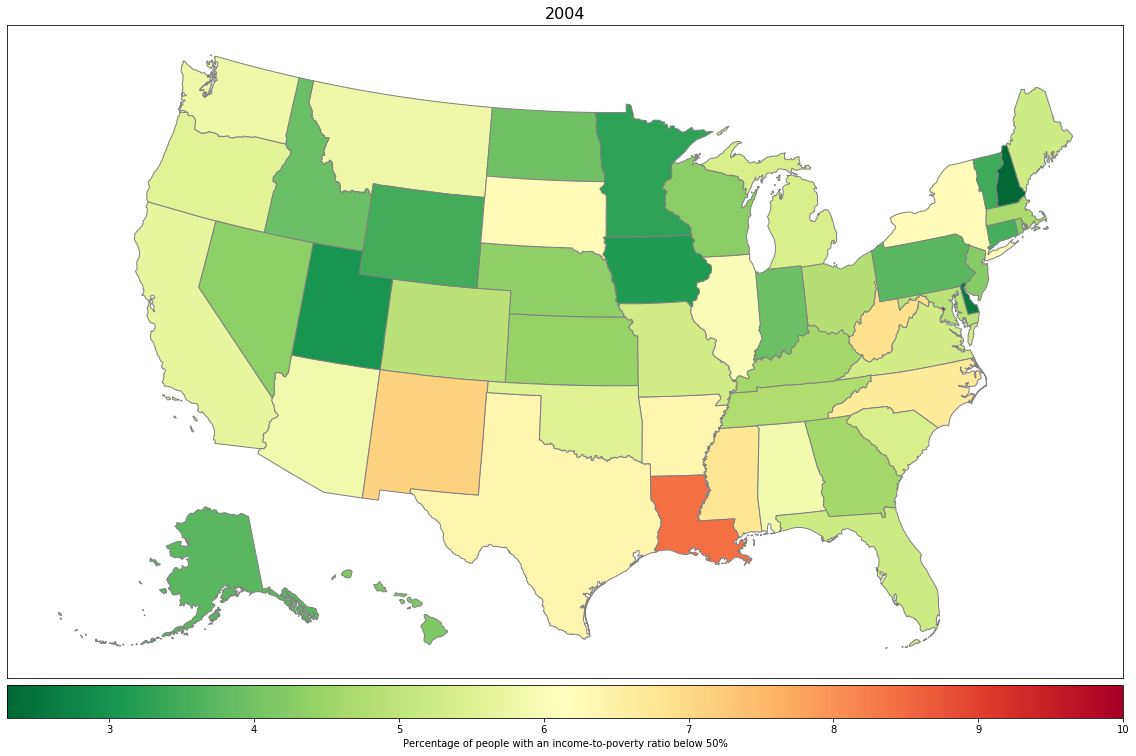

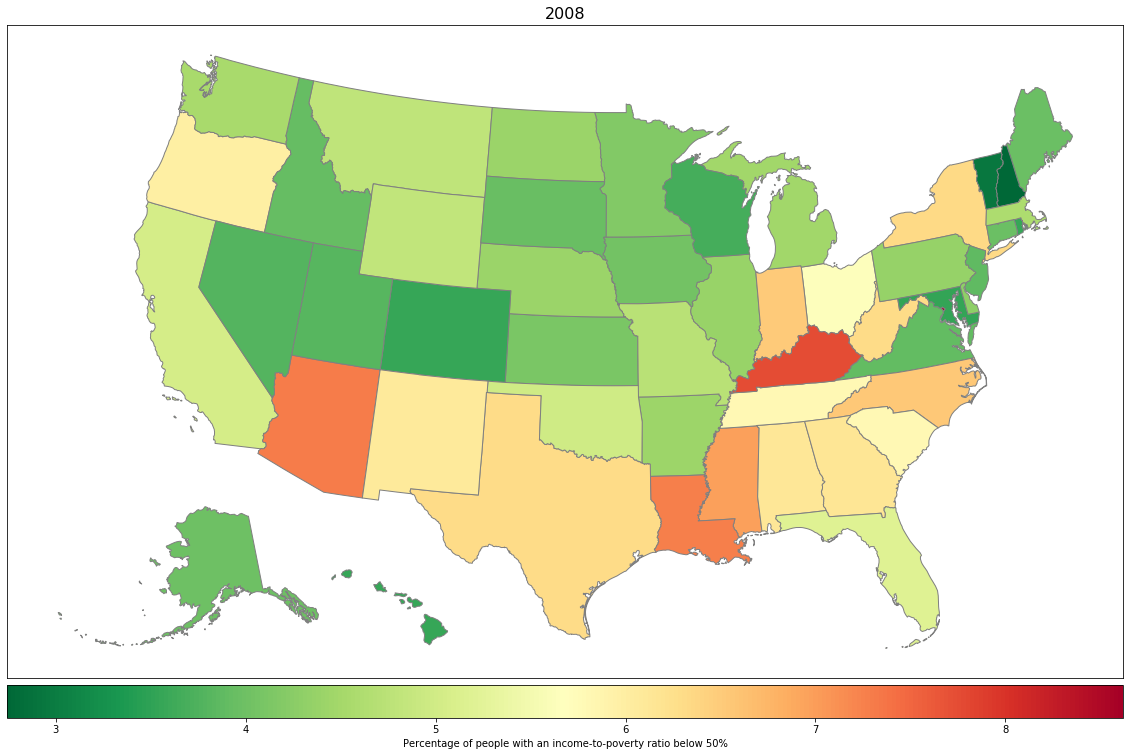

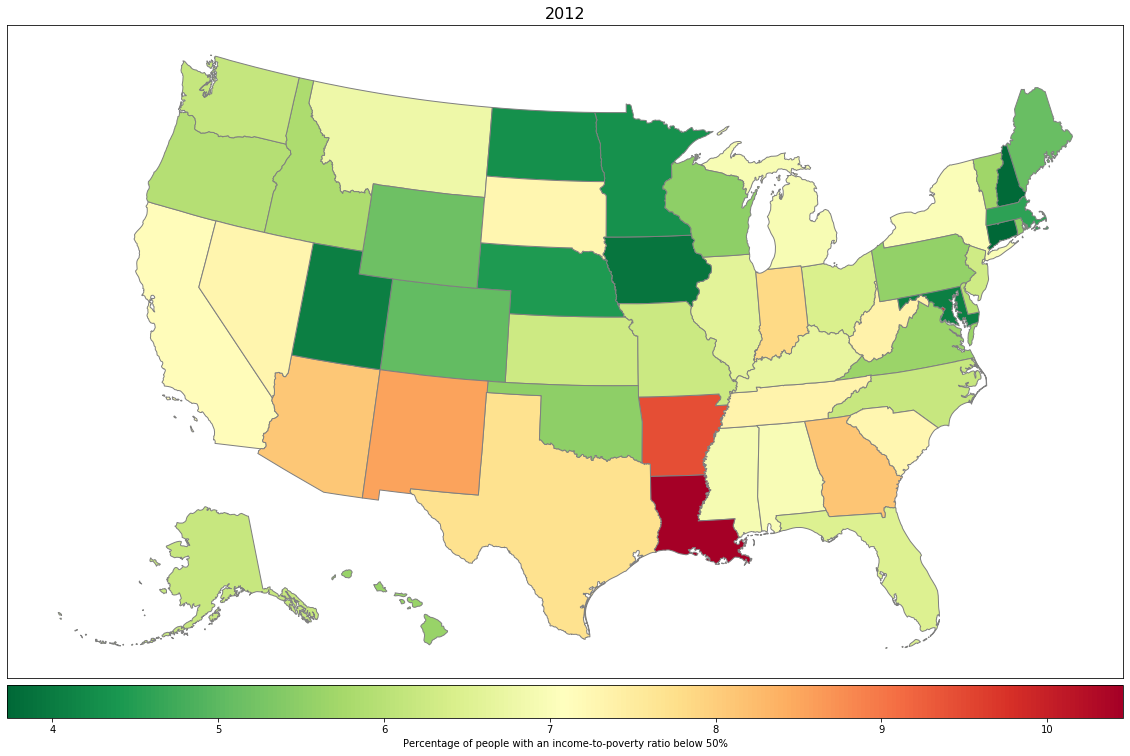

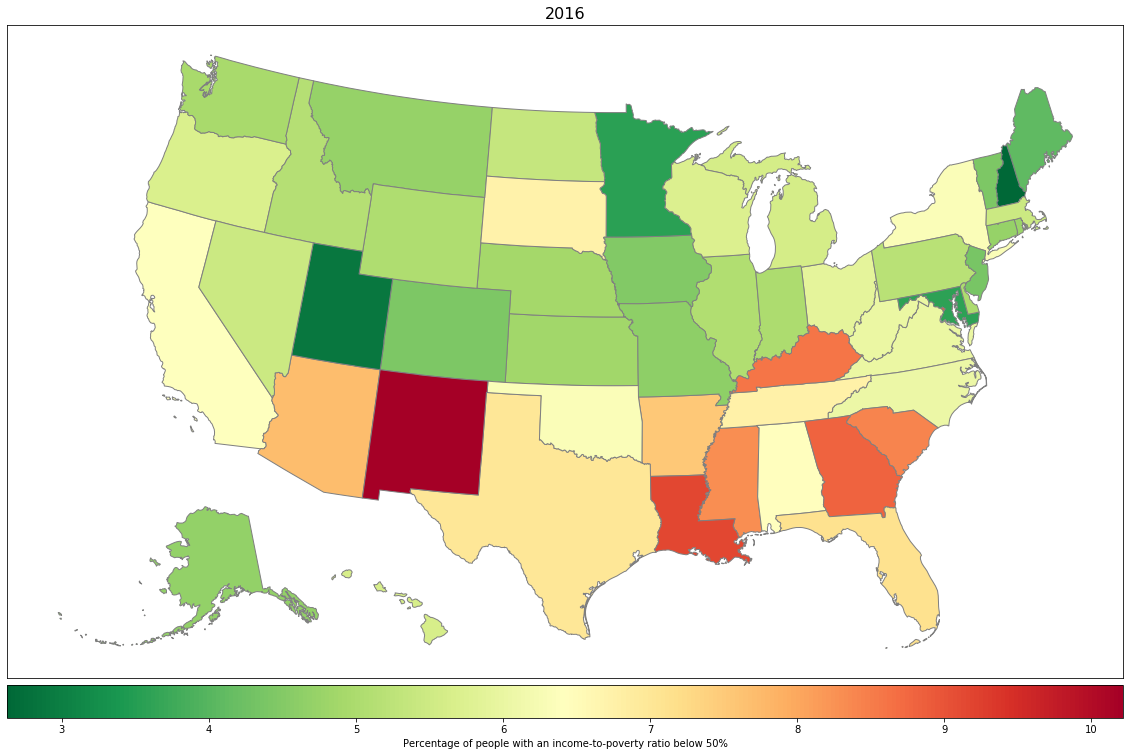

In [302]:
for key, df in states_dict.items():
    fig, ax = plt.subplots()
    plt.title(key, size='16')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    df.plot(ax=ax, column='irp_below_50', cmap='RdYlGn_r', edgecolor='grey', cax=cax, legend=True, 
            legend_kwds={'label': "Percentage of people with an income-to-poverty ratio below 50%", 'orientation': "horizontal"})

    ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()

Join all the separate dataframes into one and tidy it.

In [303]:
tidy_states_df = pd.DataFrame()
for key, df in states_dict.items():
    df = pd.DataFrame.copy(df)
    df.insert(1, "year", key)
    tidy_states_df = pd.concat([df, tidy_states_df])
tidy_states_df.head()

,geometry,year,state,state_po,party_ratio,total_pop,age_under_18,age_18_24,age_25_44,age_45_64,...,edu_child_under_15,edu_no_hs_diploma,edu_high_school,edu_some_college,edu_college_degree_plus,irp_below_50,irp_50_100,irp_100_300,irp_300_500,irp_500_plus
FID,,,,,,,,,,,,,,,,,,,,,
05,"POLYGON ((558.824 -323.366, 559.353 -323.342, ...",2016,Arkansas,AR,357.148623,2951,24.466283,8.065063,25.652321,26.363944,...,19.756015,15.249068,26.330058,21.518129,17.146730,7.522874,8.573365,41.070823,21.043714,21.789224
06,"MULTIPOLYGON (((38.962 -255.141, 38.572 -253.1...",2016,California,CA,661.282205,39081,23.351501,10.114890,27.634912,25.910289,...,19.341880,15.260613,18.341394,22.873007,24.183107,6.396970,7.525396,34.213556,21.703641,30.162995
17,"POLYGON ((625.736 -191.428, 627.145 -193.035, ...",2016,Illinois,IL,590.200514,12683,23.164866,8.578412,27.438303,25.979658,...,19.143736,11.416857,20.823149,21.635260,26.988883,5.085548,5.803043,31.325396,25.214855,32.579043
20,"POLYGON ((501.558 -245.737, 502.088 -245.737, ...",2016,Kansas,KS,388.885297,2849,26.360126,8.213408,25.517726,25.974026,...,20.849421,12.565813,19.620920,23.552124,23.446823,4.878905,9.301509,33.871534,24.464724,27.448227
28,"MULTIPOLYGON (((633.352 -373.244, 633.332 -373...",2016,Mississippi,MS,409.101527,2947,24.872752,9.026128,25.619274,26.060400,...,20.122158,16.728877,24.126230,24.465558,14.557177,8.313539,10.756702,44.451985,19.239905,17.237869


Create a scatterplot matrix to visualize the relationship of the variables

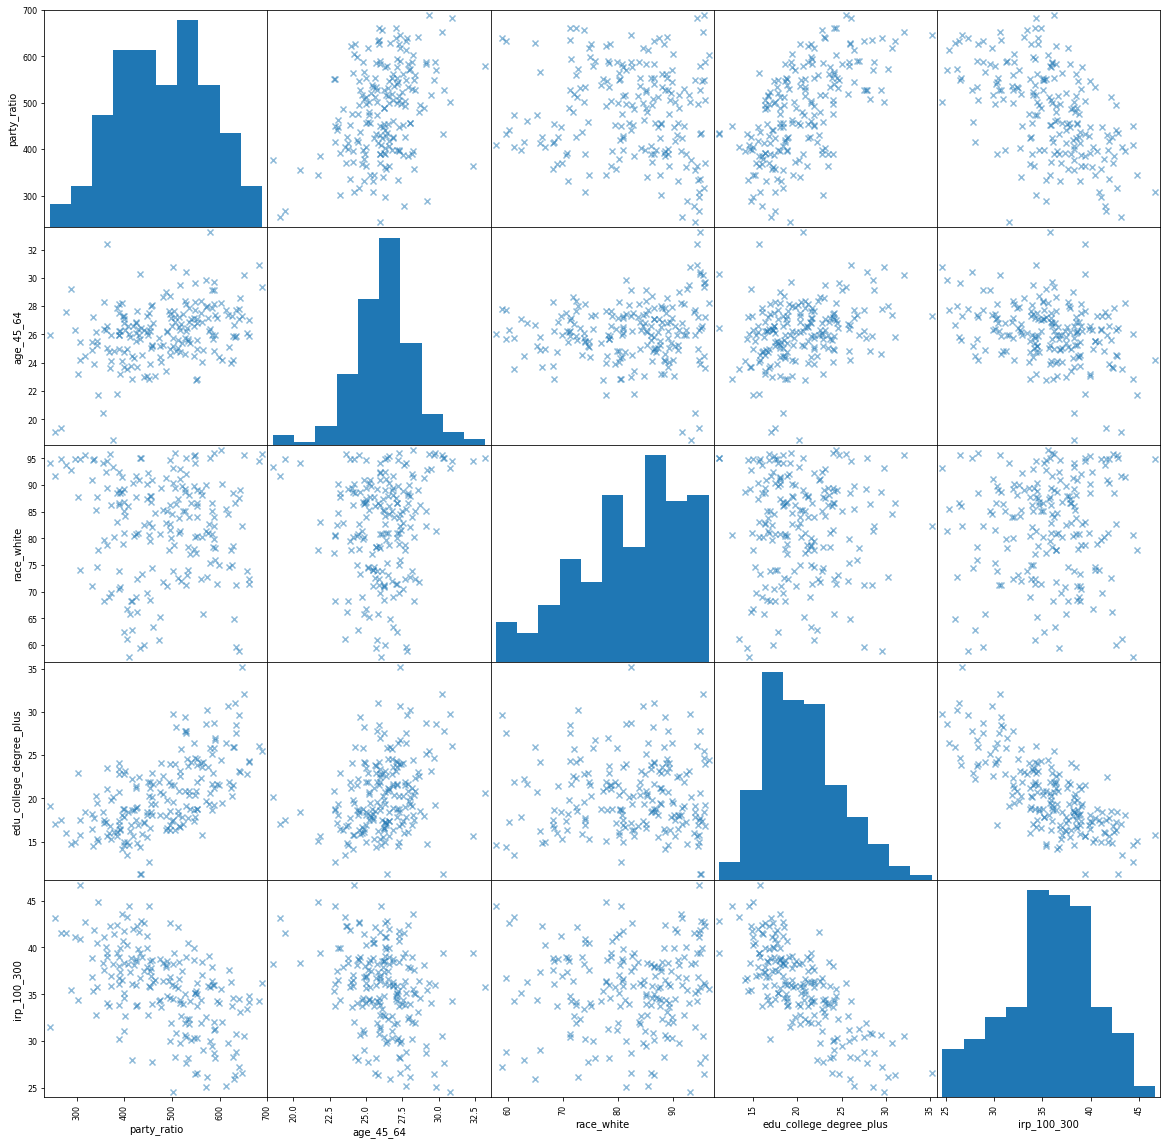

In [304]:
col = ["age_45_64", "race_white", "edu_college_degree_plus", "irp_100_300"]
col = ["party_ratio"] + col
par_df = tidy_states_df[col][(tidy_states_df.index != '11') & (tidy_states_df.index != '15')]
par_df.head()

plt.rcParams['figure.figsize'] = [20, 20]
scatter_matrix(par_df, marker='x')

plt.show()

## 4. Machine Learning

Create the independent `X` and dependent `y` variables as dataframes.

Split the test data into train and test data.

Fit the train data and create a regression model.

In [305]:
X_train = tidy_states_df[["age_45_64", "race_white", "edu_college_degree_plus"]][tidy_states_df.year < 2016]
y_train = tidy_states_df[["party_ratio"]][tidy_states_df.year < 2016]
X_test = tidy_states_df[["age_45_64", "race_white", "edu_college_degree_plus"]][tidy_states_df.year == 2016]
y_test = tidy_states_df[["party_ratio"]][tidy_states_df.year == 2016]

lm = LinearRegression()
regr = lm.fit(X_train, y_train)
regr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Run the model on the test data.

Compare the predicted `y` with the expected `y`.

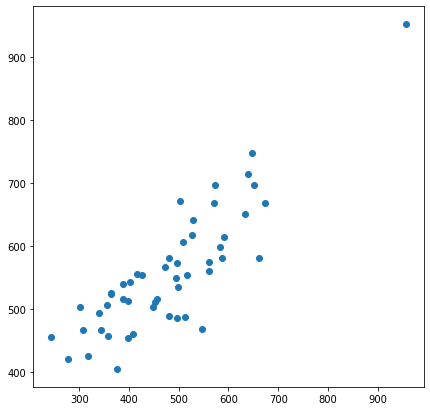

In [306]:
test = regr.predict(X_test)
plt.figure(figsize=(7, 7))
plt.scatter(y_test, test)

plt.show()

Acquire the r-squared value for the regression model.

In [307]:
regr.score(X_test, y_test)

0.3498997723819339

Read 2018 data into a new dataset.

Join the geometry column to the dataset.

In [308]:
demo_df = pd.read_csv("./data/states-demo-2018.csv")
demo_df = demo_df.set_index("state")
demo_p_df = demo_df.divide(demo_df.total_pop, axis=0) * 100
demo_p_df.total_pop = demo_df.total_pop

fid_s = states_dict[next(iter(states_dict))]["state_po"]
fid_s = pd.Series(fid_s.index.values, index = fid_s)

demo_p_df["FID"] = fid_s
demo_p_df = demo_p_df.set_index("FID")
demo_p_df = states_geo_df.join(demo_p_df)
demo_p_df.head()

,geometry,total_pop,age_under_18,age_18_24,age_25_44,age_45_64,age_65_plus,race_white,race_black,race_native,...,edu_child_under_15,edu_no_hs_diploma,edu_high_school,edu_some_college,edu_college_degree_plus,irp_below_50,irp_50_100,irp_100_300,irp_300_500,irp_500_plus
FID,,,,,,,,,,,,,,,,,,,,,
05,"POLYGON ((558.824 -323.366, 559.353 -323.342, ...",2924,24.384405,9.678523,24.555404,25.034200,16.381669,78.864569,15.424077,0.786594,...,19.357045,15.663475,25.000000,21.819425,18.194254,6.497948,8.276334,41.244870,21.614227,22.400821
06,"MULTIPOLYGON (((38.962 -255.141, 38.572 -253.1...",39237,22.970665,8.996610,29.199480,24.568647,14.264597,72.617682,6.356245,1.396641,...,18.900528,14.654535,18.107908,22.476234,25.860795,5.698703,6.718149,33.659556,21.461885,32.464256
17,"POLYGON ((625.736 -191.428, 627.145 -193.035, ...",12604,22.960965,9.441447,26.102825,26.309108,15.185655,76.864487,14.281181,0.864805,...,18.232307,11.464614,21.342431,21.635989,27.316725,4.974611,5.966360,29.641384,25.817201,33.600444
20,"POLYGON ((501.558 -245.737, 502.088 -245.737, ...",2870,24.459930,9.268293,26.132404,22.787456,17.386760,86.062718,5.749129,1.045296,...,20.836237,11.463415,20.940767,22.055749,24.703833,6.515679,8.188153,30.278746,25.017422,30.000000
28,"MULTIPOLYGON (((633.352 -373.244, 633.332 -373...",2947,24.024432,8.890397,25.687139,25.721072,15.676960,58.839498,37.699355,0.644723,...,19.714964,15.507296,23.820835,24.194096,16.762810,8.279606,9.976247,40.210383,23.617238,17.916525


Map the predicted results for 2018.

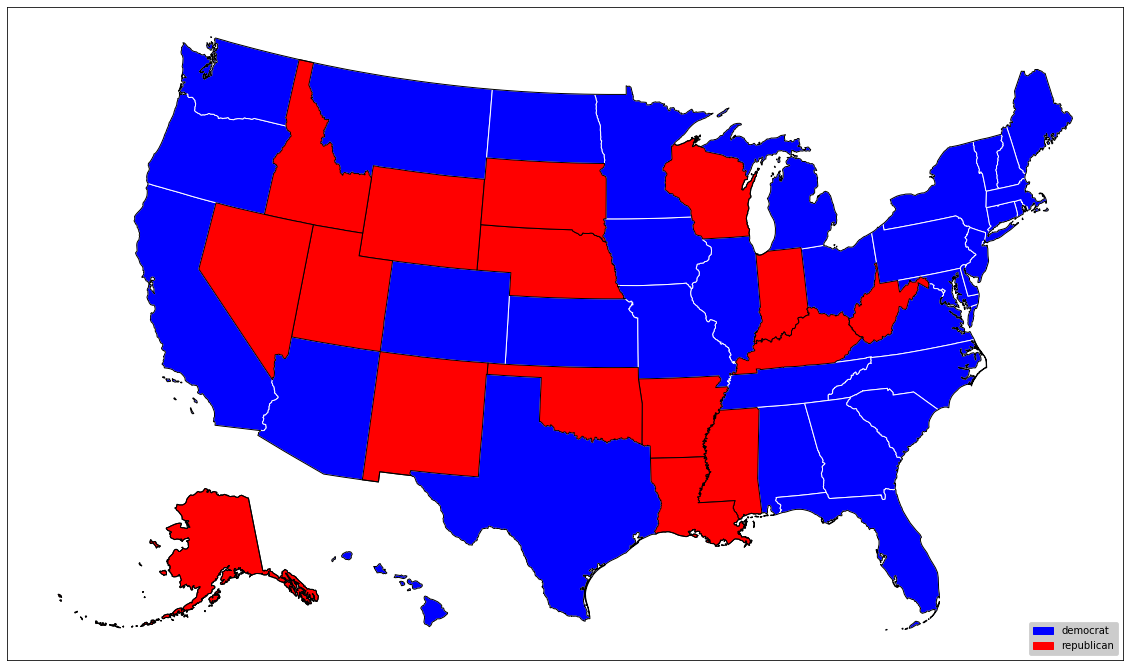

In [309]:
X_pred = demo_p_df[["age_45_64", "race_white", "edu_college_degree_plus"]]
y_pred = lm.predict(X_pred)

pred_df = pd.DataFrame.copy(demo_p_df)
pred_df.insert(1, "pred_ratio", lm.predict(X_pred))

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
pred_df[pred_df.pred_ratio > 500].plot(ax=ax, color='blue', edgecolor='white')
pred_df[pred_df.pred_ratio < 500].plot(ax=ax, color='red', edgecolor='black')
nation.plot(ax=ax, edgecolor='black', color='none')

blue_patch = mpatches.Patch(color='blue', label='democrat')
red_patch = mpatches.Patch(color='red', label='republican')
leg = ax.legend(handles = [blue_patch, red_patch], frameon=True, 
                loc='lower right', bbox_to_anchor=(1, 0))
frame = leg.get_frame()
frame.set_facecolor('silver')

ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()

A different coloring option.

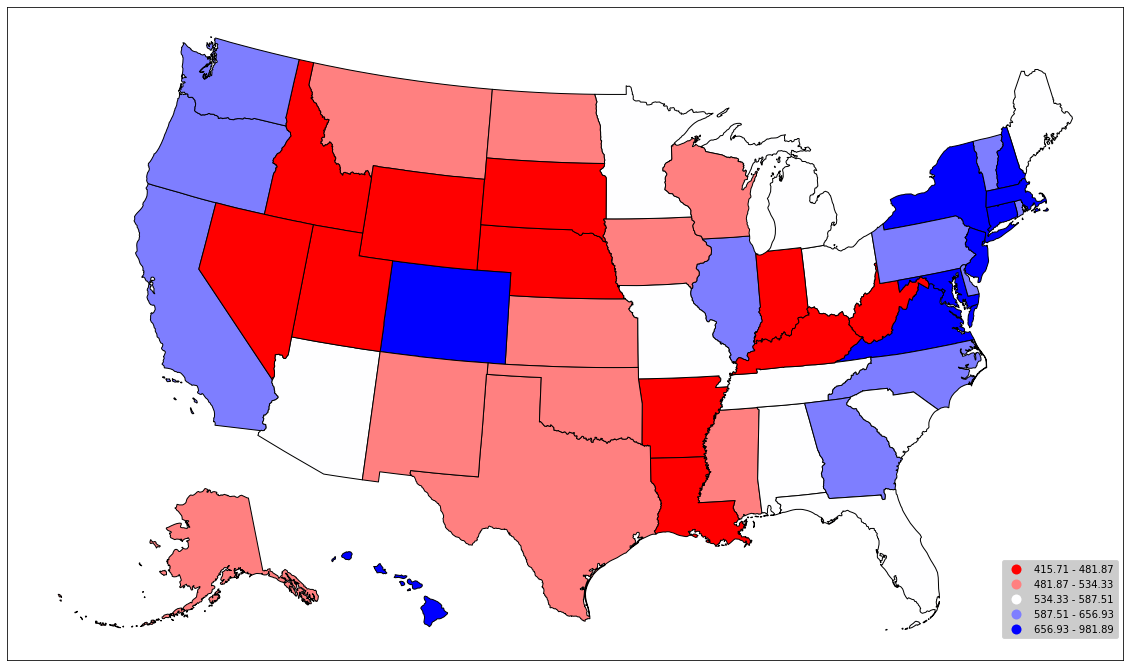

In [310]:
fig, ax = plt.subplots()
pred_df.plot(ax=ax, column='pred_ratio', cmap='bwr_r', scheme='quantiles', edgecolor='black', legend=True)
nation.plot(ax=base, edgecolor='black', color='none')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.16))
frame = leg.get_frame()
frame.set_facecolor('silver')

plt.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()

View statistical analysis of the regression model.

In [311]:
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('R-squared: %.2f' 
      % regr.score(X_test, y_test))

Coefficients: 
 [[ 9.31567617 -2.14176161 15.98993999]]
Mean squared error: 12442.84
Coefficient of determination: 0.23
R-squared: 0.35


Run the a new model by randomly splitting the `tidy_states_df`.

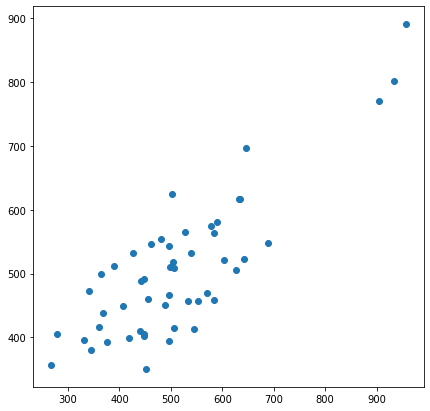

In [312]:
X_2 = tidy_states_df[["age_45_64", "race_white", "edu_college_degree_plus"]]
y_2 = tidy_states_df[["party_ratio"]]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=51, random_state=101)

lm_2 = LinearRegression()
regr_2 = lm_2.fit(X_train_2, y_train_2)

test_2 = regr_2.predict(X_test_2)
plt.figure(figsize=(7, 7))
plt.scatter(y_test_2, test_2)

plt.show()

In [313]:
regr_2.score(X_test_2, y_test_2)

0.6811194737033199

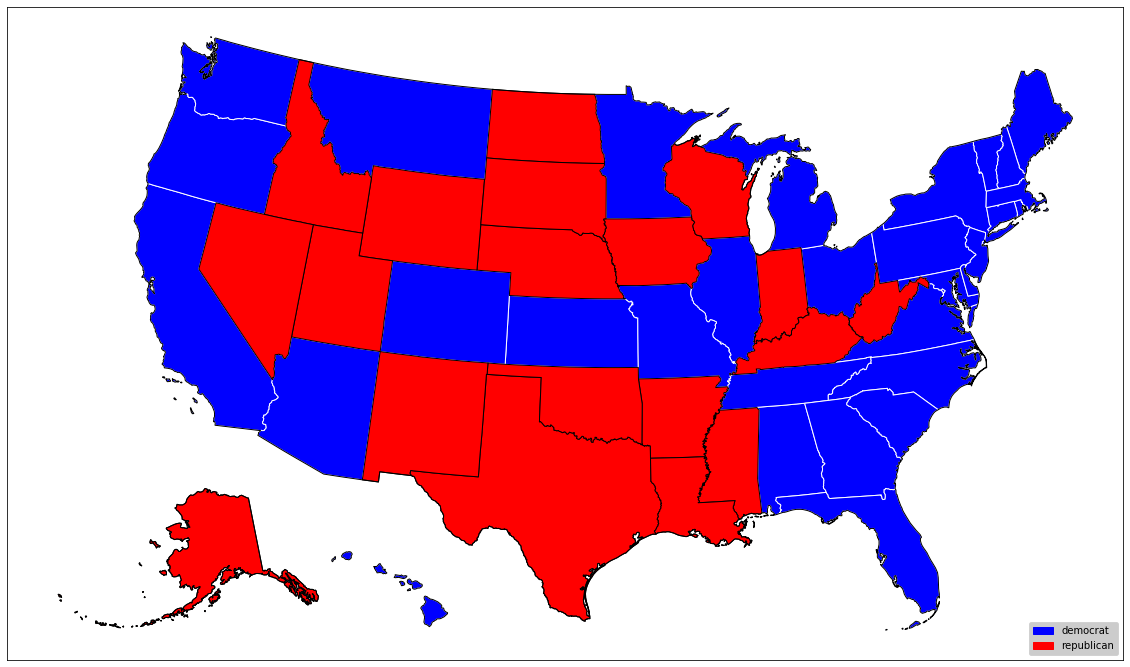

In [314]:
y_pred_2 = lm_2.predict(X_pred)

pred_df_2 = pd.DataFrame.copy(demo_p_df)
pred_df_2.insert(1, "pred_ratio", lm_2.predict(X_pred))

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
pred_df_2[pred_df_2.pred_ratio > 500].plot(ax=ax, color='blue', edgecolor='white')
pred_df_2[pred_df_2.pred_ratio < 500].plot(ax=ax, color='red', edgecolor='black')
nation.plot(ax=ax, edgecolor='black', color='none')

blue_patch = mpatches.Patch(color='blue', label='democrat')
red_patch = mpatches.Patch(color='red', label='republican')
leg = ax.legend(handles = [blue_patch, red_patch], frameon=True, 
                loc='lower right', bbox_to_anchor=(1, 0))
frame = leg.get_frame()
frame.set_facecolor('silver')

ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()

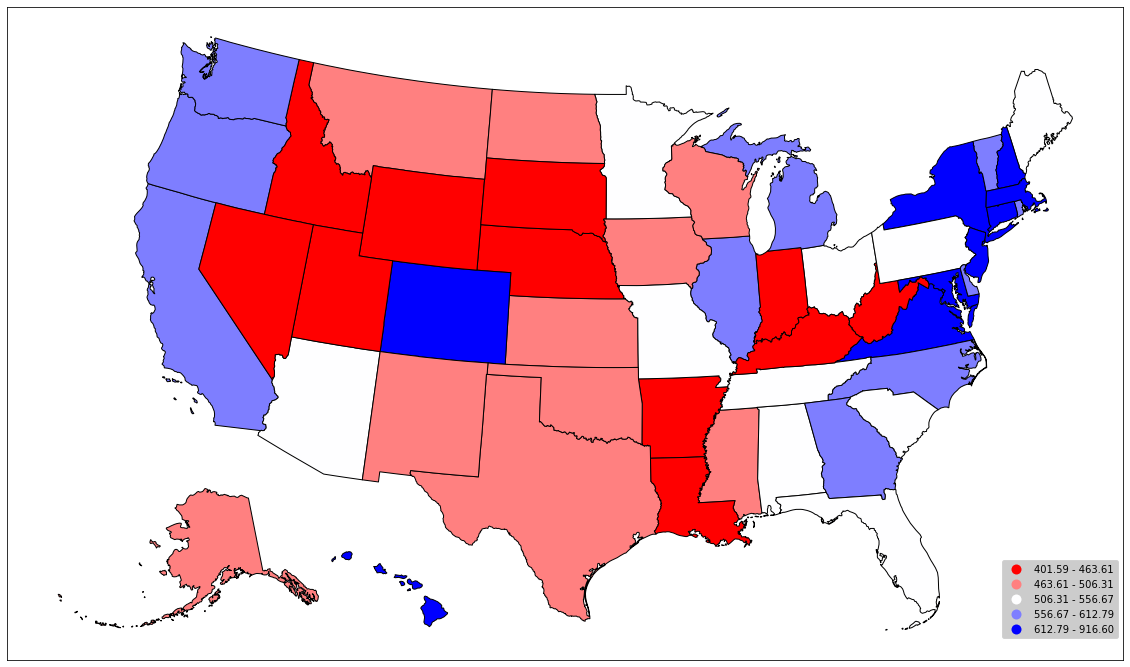

In [315]:
fig, ax = plt.subplots()
pred_df_2.plot(ax=ax, column='pred_ratio', cmap='bwr_r', scheme='quantiles', edgecolor='black', legend=True)
nation.plot(ax=base, edgecolor='black', color='none')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.16))
frame = leg.get_frame()
frame.set_facecolor('silver')

plt.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)

plt.show()